# Imports and Defaults

In [9]:
# import subprocess
# subprocess.run(["pip", "install", "-q", "-e", "../bayes-kit"])

In [10]:
import json
import os
from itertools import product
from collections import defaultdict

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from tqdm import trange

from src.utils import get_model
from bayes_kit.ess import ess
from bayes_kit.rhat import rhat


In [3]:
# SET THESE VALUES
PDB_DIR = "models"
RES_DIR = "res"
FIGURE_DIR = "figures"
MODEL_NUM = 1

In [4]:
# DEFAULTS
ROOT_DIR = os.path.join(RES_DIR, f"PDB_{MODEL_NUM:02d}")
SAMPLER_DIRS = next(os.walk(ROOT_DIR))[1]

plt.ioff()
sns.set_style("darkgrid")
mplstyle.use('fast')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
# %config InlineBackend.figure_format = "svg" # "retina"

# DataFrame and Plots Generation

In [5]:
def init():
    num_samplers = len(SAMPLER_DIRS)

    fname = os.path.join(ROOT_DIR, SAMPLER_DIRS[0])
    num_chains = len(next(os.walk(fname))[1])

    fname = os.path.join(ROOT_DIR, SAMPLER_DIRS[0], "chain_01", "draws.npy")
    draws = np.load(fname)
    num_model_params = draws.shape[1]
    
    return num_samplers, num_chains, num_model_params

def init_reference():
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    num_ref_chains = np.load(fname).shape[0]
    return num_ref_chains

In [6]:
def get_draws(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "draws.npy")
    draws = np.load(fname).astype(np.float32)
    return draws

def get_burned_draws(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "burned_draws.npy")
    burned_draws = np.load(fname).astype(np.float32)
    return burned_draws


def parse(sampler_params):
    # remove sampler params that are not relevant to the experiment
    include_keys = ["sampler_type"]
    parsed = []
    
    for key in list(sampler_params.keys()):
        if key in include_keys:
            parsed.append(str(sampler_params[key]))
            
    return "\n".join(parsed) # split by newline


def get_sampler_params(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "sampler_params.json")
    with open(fname) as f:
        sampler_params = json.load(f)
    return sampler_params


def extract_my_data(sampler_num, chain_num):
    sampler_dir = SAMPLER_DIRS[sampler_num]
    
    draws = get_draws(sampler_dir, chain_num)
    burned_draws = get_burned_draws(sampler_dir, chain_num)
    sampler_params = get_sampler_params(sampler_dir, chain_num)
    return draws, burned_draws, sampler_params


def get_ref_draws(chain_num):
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    
    constrained = np.load(fname)[chain_num, :, :].copy(
        order="C"
    )  # [chain_num, n_samples, params_dim]
    reference_draws = model.unconstrain(constrained).astype(np.float32)
    return reference_draws

def plot_stats_df(stats_df, num_samplers):
    max_num_proposals = 4
    accept_list = [f"accept_{i}" for i in range(max_num_proposals)]

    melted = pd.melt(stats_df, id_vars=["model_param", "sampler", "chain"], 
                     value_vars=["mean", "std", "rhat", "ess/grad_eval", "ess^2/grad_eval", "accept_total"] + accept_list
    )
    stats_fig = sns.catplot(data=melted, x="sampler", y="value", 
                row="model_param", col="variable", 
                hue="sampler", aspect= num_samplers / 20,
                sharex=False, sharey=False, legend=True)
    fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "stats.svg")
    stats_fig.savefig(fname)
    fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "stats.pdf")
    stats_fig.savefig(fname)
    
    return stats_fig

In [7]:
def eval(num_samplers, num_chains, num_model_params, num_ref_chains):
    hist_fig, hist_axes = plt.subplots(nrows=num_model_params, ncols=num_chains, sharex="row", sharey="row",
                                       figsize=(num_chains*4.5, num_model_params*3.5,), 
    )
    chain_fig, chain_axes = plt.subplots(nrows=num_model_params, ncols=num_samplers, sharey="row",
                                         figsize=(num_samplers*3, num_model_params*4),
    )
    stats_df_list = []
    for sampler in trange(num_samplers):
        rhat_dict = defaultdict(list)
        for chain in range(num_chains):
            
            all_draws, all_burned_draws, sampler_params = extract_my_data(sampler, chain)
            for model_param in range(num_model_params):
                # pre-processing
                draws, burned_draws = all_draws[:, model_param], all_burned_draws[:, model_param]
                rhat_dict[model_param].append(draws)
                
                # histogram plotting
                sns.histplot(draws, ax=hist_axes[model_param, chain], 
                             stat="density", fill=False, element="step", linewidth=0.5,
                             label=f"sampler {sampler}" if model_param + chain == 0 else "",
                ).set_title(f"Model Param {model_param} | Chain {chain}")
                
                # chains plotting
                x = np.arange(sampler_params["burn_in"])
                sns.lineplot(x=x, y=burned_draws, ax=chain_axes[model_param, sampler], 
                             linewidth=0.2,
                             label=f"chain {chain}" if sampler + model_param == 0 else "",
                ).set_title(f"Model Param {model_param} | Sampler {sampler}")
                x = np.arange(sampler_params["burn_in"], sampler_params["burn_in"] + sampler_params["chain_length"])
                sns.lineplot(x=x, y=draws, ax=chain_axes[model_param, sampler],
                            linewidth=0.2, color=chain_axes[model_param, sampler].get_lines()[-1].get_color(),
                )
                chain_axes[model_param, sampler].axvline(x=sampler_params["burn_in"], color="black")
                
                # stats dataframe
                stats_row = {
                    "model_param": model_param,
                    "sampler": sampler,
                    "chain": chain,
                    "mean": np.mean(draws),
                    "std": np.std(draws),
                    "ess/grad_eval": ess(draws) / sampler_params["grad_evals"],
                    "ess^2/grad_eval": ess(draws**2) / sampler_params["grad_evals"],
                }
                for k, v in sampler_params.items():
                    stats_row[k] = v
                stats_row["sampler_params"] = "\n".join(f"{k}: {v}" for k, v in sampler_params.items())
                stats_df_list.append(stats_row)
                
        # stats dataframe
        for model_param in range(num_model_params):
            rhat_val = rhat(rhat_dict[model_param])
            for chain in range(num_chains):
                idx = (sampler * num_chains * num_model_params) + (chain * num_model_params) + model_param
                stats_row = stats_df_list[idx]
                stats_row["rhat"] = rhat_val
                
    # reference draws
    ref_dict = defaultdict(list)
    for chain in range(num_ref_chains):
        all_ref_draws = get_ref_draws(chain)
        for model_param in range(num_model_params):
            # pre-processing
            ref_draws = all_ref_draws[:, model_param]
            ref_dict[model_param].append(ref_draws)
            
            # histplot
            sns.histplot(ref_draws, ax=hist_axes[model_param, chain], 
                         stat="density", fill=False, element="step", linewidth=1.5, color="black",
                         label="ref" if model_param + chain == 0 else "",
            )
            
            # stats dataframe
            stats_row = {
                "model_param": model_param,
                "sampler": -1,
                "chain": chain,
                "mean": np.mean(ref_draws),
                "std": np.std(ref_draws),
            }
            stats_df_list.append(stats_row)
    
    # stats dataframe
    for model_param in range(num_model_params):
        rhat_val = rhat(ref_dict[model_param])
        for chain in range(num_chains):
            idx = idx = (num_samplers * num_chains * num_model_params) + (chain * num_model_params) + model_param
            stats_row = stats_df_list[idx]
            stats_row["rhat"] = rhat_val
            
    # stats post-processing
    stats_df = pd.DataFrame(stats_df_list).sort_values(by=["model_param", "sampler", "chain"])
    stats_fig = plot_stats_df(stats_df, num_samplers)
    
    # histogram post-processing
    hist_fig.legend(loc="upper right")
    hist_fig.tight_layout()
    hist_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "histogram.svg")
    hist_fig.savefig(hist_fname)
    hist_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "histogram.pdf")
    hist_fig.savefig(hist_fname)
    
    # chain post-processing
    chain_fig.legend(loc="upper right")
    chain_fig.tight_layout()
    chain_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "chain.svg")
    chain_fig.savefig(chain_fname)
    chain_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "chain.pdf")
    chain_fig.savefig(chain_fname)
                               
    return hist_fig, chain_fig, stats_fig, stats_df

# Evaluatation

100%|██████████| 288/288 [41:12<00:00,  8.58s/it]


ValueError: Image size of 216000x7500 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x15550da1b420> (for post_execute):


ValueError: Image size of 259200x6000 pixels is too large. It must be less than 2^16 in each direction.

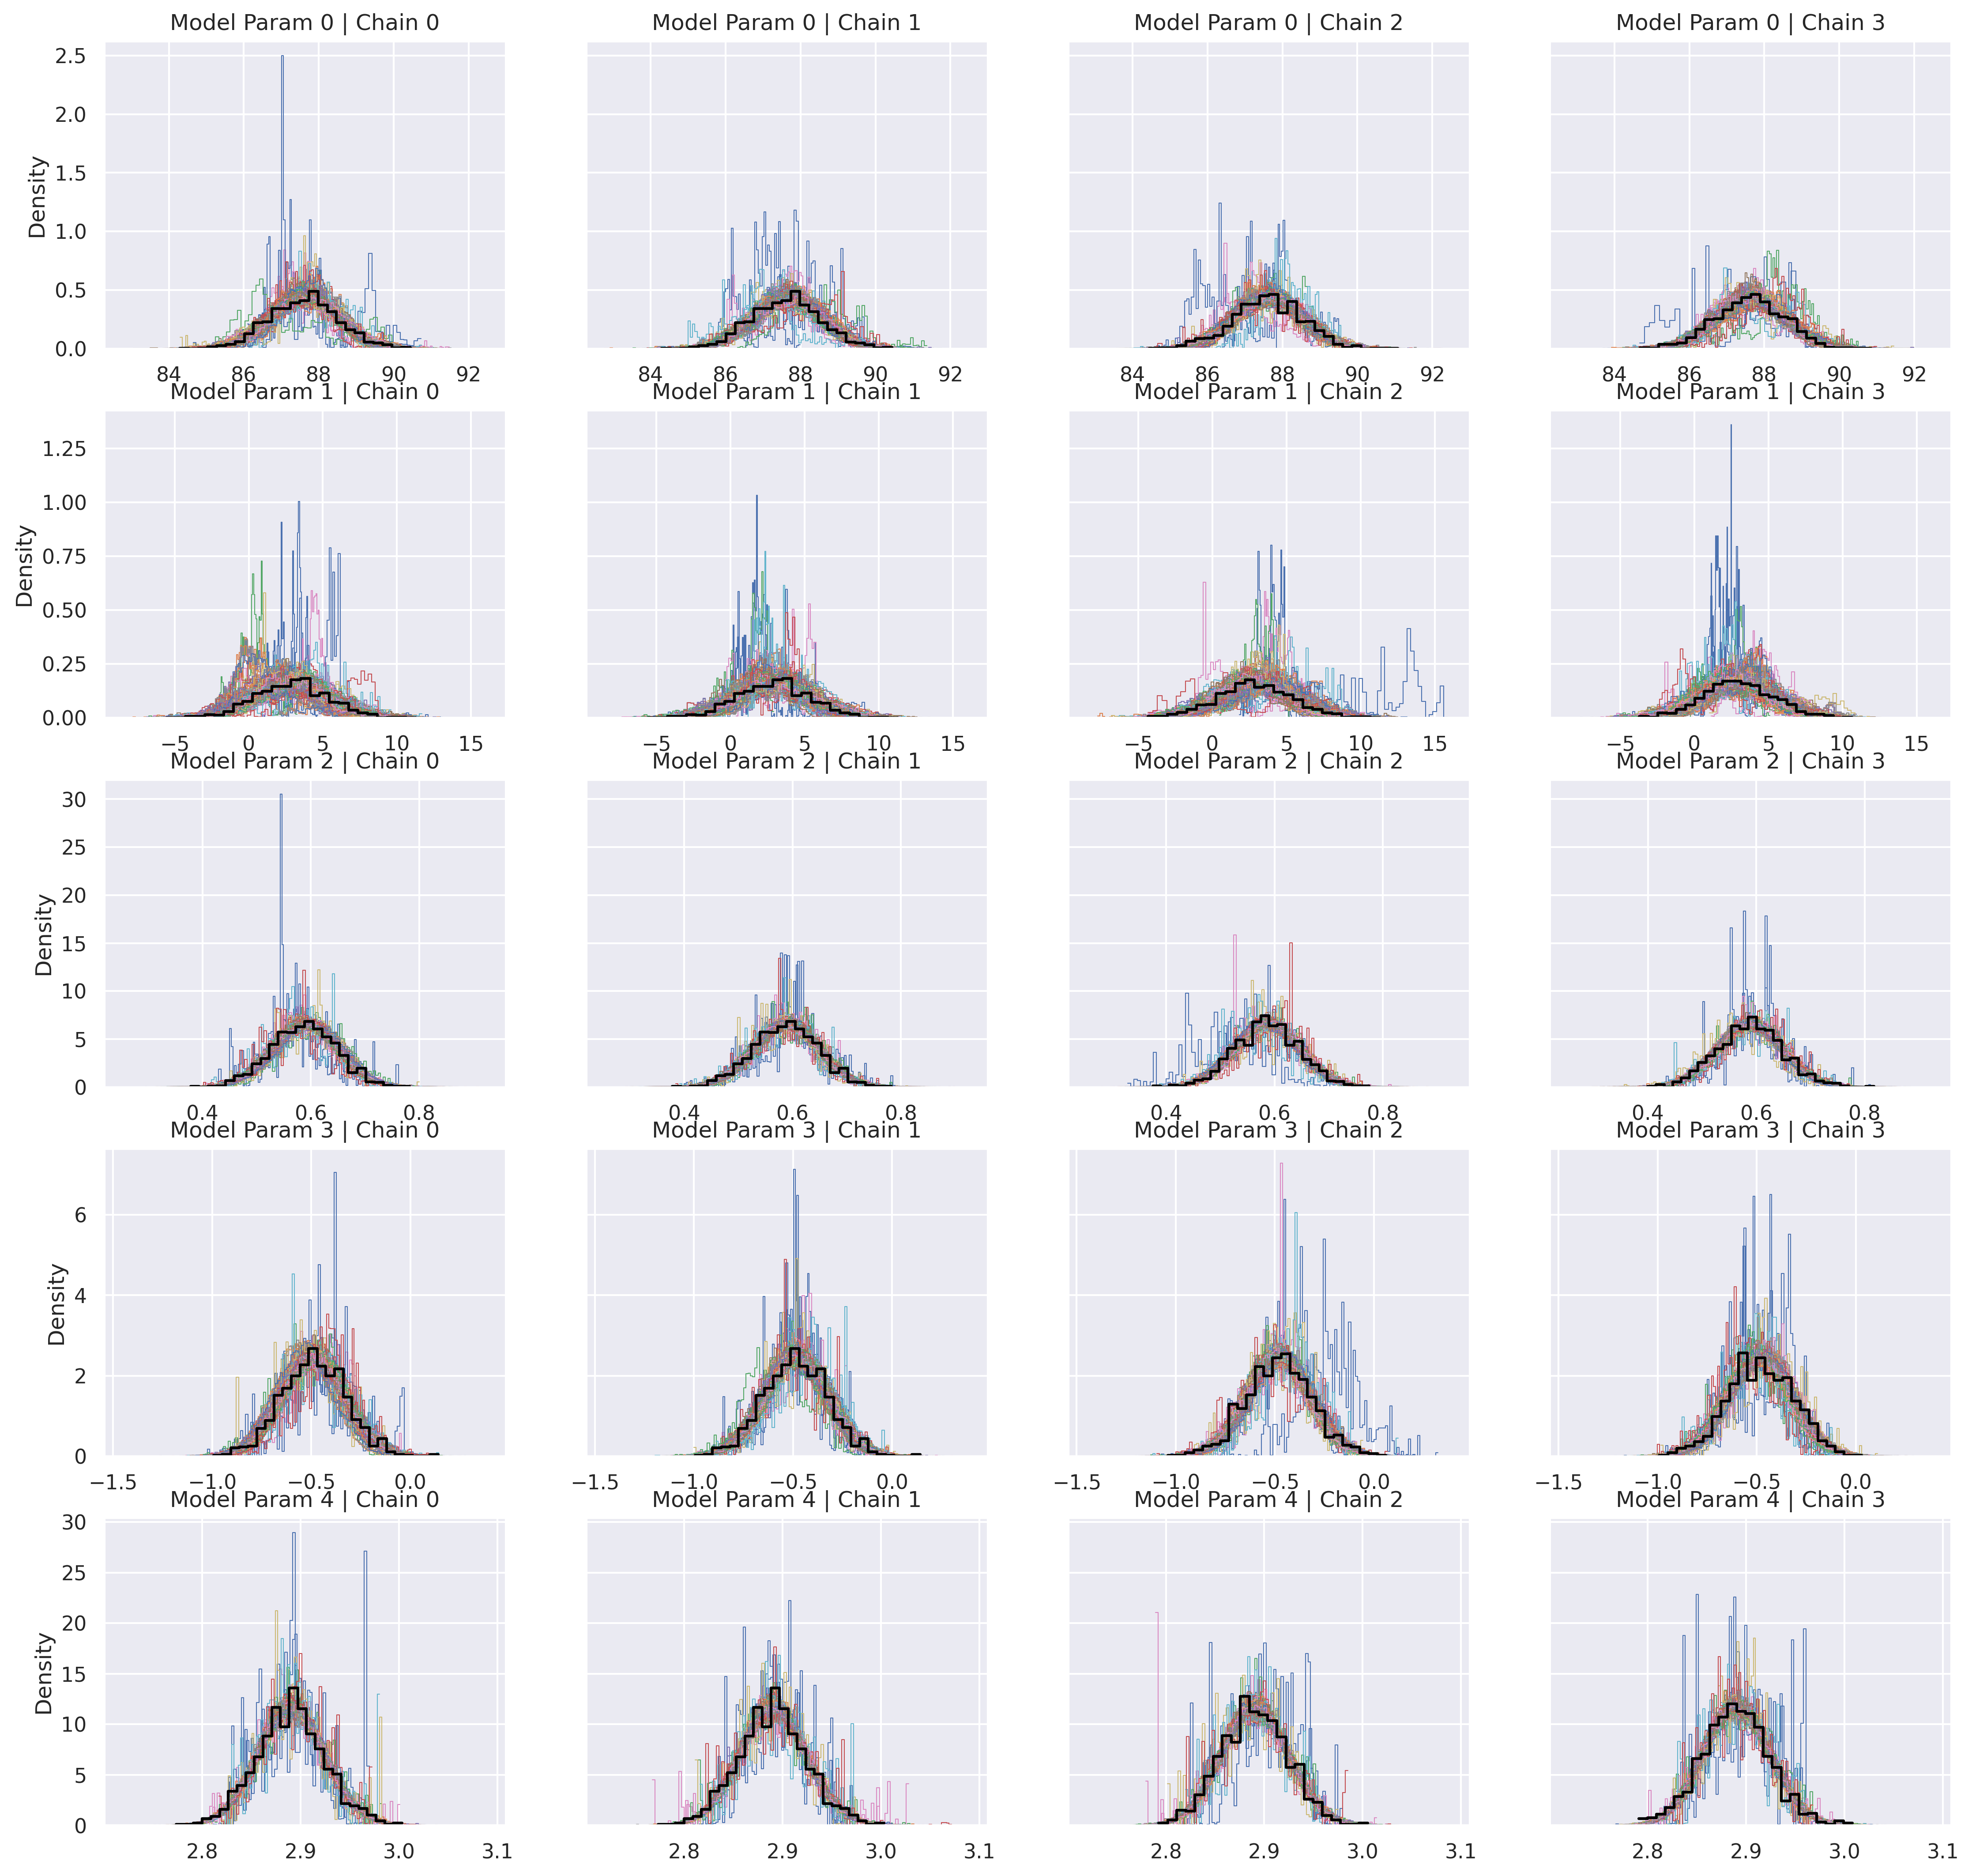

ValueError: Image size of 259200x6000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 259200x6000 with 1440 Axes>

ValueError: Image size of 216000x7500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 216000x7500 with 50 Axes>

In [8]:
num_samplers, num_chains, num_model_params = init()
num_ref_chains = init_reference()

hist_fig, chain_fig, stats_fig, stats_df = eval(
    num_samplers, num_chains, num_model_params, min(num_ref_chains, num_chains)
)

In [ ]:
stats_df.head(10)